__Implement 4c, 4d, and 4f.  Plot graphs (histograms?) to show the sample data__

## Handling sample selection bias

The use of linear models, where possible, simplifies causal reasoning and allows one to use linear regression to determine path coefficients relating values.  They make life a lot easier.

This notebook shows how path coefficients are calculated on a synthetic dataset where we can control the correct values.  The dataset construction code is in dataset_N.py for N = 01, 02, 03 and useful functions are defined in causal_utils.py, all in the current directory.


In [1]:
import importlib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import os
from random import random, seed, uniform, gauss
import re
import sys

from sklearn.linear_model import LinearRegression


In [2]:
import causal_utils as u

In [3]:
# Set a seed so that the results are reproducible.  The value is arbitrary and everything works without it

seed(12345)
np.random.seed(12345)

In [4]:
%matplotlib inline

pd.options.display.max_rows = 250
pd.options.display.max_columns = 125
pd.options.display.max_colwidth = 250

nx_options = {
    'node_color': 'orange',
    "edge_color": "blue",
    "with_labels": True,
    "font_weight": 'bold',
    "font_size": 12,
    'node_size': 1200,
    'width': 1,
    "arrowsize": 15,
}

# The accuracy is okay with 100k observations but a milion is better.
num_data_elts = 1_000_000


In [5]:
dataset_index = 2

assert dataset_index in [1, 2]

In [6]:
if dataset_index == 1:
    import sample_selection_bias_dataset_01 as dataset
    from sample_selection_bias_dataset_01 import g, draw_fn, observation

elif dataset_index == 2:
    import sample_selection_bias_dataset_02 as dataset
    from sample_selection_bias_dataset_02 import g, draw_fn, observation


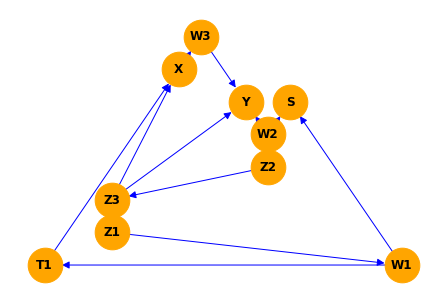

In [7]:
draw_fn(g, **nx_options)

In [8]:
data = [dataset.observation() for _ in range(num_data_elts)]
df = pd.DataFrame(data, columns=sorted(g.nodes))

In [9]:
dfs = df.loc[df.S == 1]

In [10]:
u.estimated_coefficients(g, df)

T1 X 1.000000
W1 S 0.032520
W1 T1 2.299700
W2 S 0.028960
W2 Y 4.000050
W3 Y 2.999960
X W3 -2.000000
Z1 W1 2.999980
Z1 Z3 -0.998870
Z2 W2 2.194820
Z2 Z3 7.002280
Z3 X -1.499990
Z3 Y 1.750100


In [11]:
u.estimated_coefficients(g, dfs)

T1 X 0.999970
W1 S 0.000000
W1 T1 2.299000
W2 S 0.000000
W2 Y 3.999810
W3 Y 3.000020
X W3 -2.000020
Z1 W1 2.933260
Z1 Z3 -0.996500
Z2 W2 1.554060
Z2 Z3 7.001920
Z3 X -1.499990
Z3 Y 1.749820


In [12]:
if dataset_index == 1:
    controlled_sets = [
        ["X", "W1", "W2", "Z"],
        ["X", "W1", "W2"],
        ["X", "Z"],
    ]


In [14]:
if dataset_index == 2:
    controlled_sets = [
        ["X", "Z1", "Z2", "Z3"],
        ["X", "T1", "W1", "W2", "Z1", "Z2", "Z3"],
    ]


In [17]:
for control in controlled_sets:
    print(control)
    print("all  ", u.path_coefficients(df, "Y", control))
    print("S = 1", u.path_coefficients(dfs, "Y", control))
    print()

print("empirical total effect of X on Y:")
for _ in range(5):
    print(u.empirical_total_effect(g, dataset, "X", "Y",
                                   lambda *a: 1, lambda *a: 2,
                                   num_data_elts=100_000))


['X', 'Z1', 'Z2', 'Z3']
all   {'X': -6.00426, 'Z1': 0.00287, 'Z2': 8.81856, 'Z3': 1.73793}
S = 1 {'X': -6.65143, 'Z1': -1.49436, 'Z2': 4.85569, 'Z3': 0.77239}

['X', 'T1', 'W1', 'W2', 'Z1', 'Z2', 'Z3']
all   {'X': -6.0024, 'T1': 0.00203, 'W1': 0.00096, 'W2': 4.00029, 'Z1': -0.00109, 'Z2': 0.00396, 'Z3': 1.74567}
S = 1 {'X': -6.00929, 'T1': 0.00967, 'W1': -0.00271, 'W2': 4.00045, 'Z1': 0.00385, 'Z2': 0.00505, 'Z3': 1.73511}

empirical total effect of X on Y:
-6.104733679537095
-6.055417609378295
-5.911435279392066
-5.801992947418718
-5.971087710795104


In [ ]:
draw_fn(g, **nx_options)

In [ ]:
1/0

In [ ]:
# Because of the way we define the dataset functions, we can access the actual coefficients used in them

u.actual_coefficients(dataset.__dict__)

In [ ]:
# These are the estimates for the coefficients produced by linear regression

u.estimated_coefficients(g, df)

By using the Python unittest mocking library, we can implement the do(V=v) operator without altering the source code.  This allows us to validate that regression really has given us the right answers

In [ ]:
if dataset_index == 1:
    # total effect of B on Y = direct effect + effect via X
    print("%-11s %5.3f" % ("theoretical",
                           dataset.B_Y_coeff + dataset.B_X_coeff * dataset.X_Y_coeff))
    print()
    
    for sample in range(5):
        print("%-11s %5.3f" % ("empirical",
                               u.empirical_total_effect(g, dataset, "B", "Y",
                                                        lambda *a: 1, lambda *a: 2,
                                                        num_data_elts=num_data_elts)))

In [ ]:
if dataset_index == 2:
    # total effect of X on Y = effect via A + effect via D
    print("%-11s %5.3f" % ("theoretical",
                           dataset.X_A_coeff * dataset.A_Y_coeff + dataset.X_D_coeff * dataset.D_Y_coeff))
    print()
    
    for sample in range(5):
        print("%-11s %5.3f" % ("empirical",
                               u.empirical_total_effect(g, dataset, "X", "Y",
                                                        lambda *a: 1, lambda *a: 2,
                                                        num_data_elts=num_data_elts)))

In [ ]:
if dataset_index == 3:
    # total effect of Z3 on Y = direct effect + effect via X and W
    print("%-11s %5.3f" % ("theoretical",
                           dataset.Z3_Y_coeff + dataset.Z3_X_coeff * dataset.X_W_coeff * dataset.W_Y_coeff))
    print()
    
    for sample in range(5):
        print("%-11s %5.3f" % ("empirical",
                               u.empirical_total_effect(g, dataset, "Z3", "Y",
                                                        lambda *a: 1, lambda *a: 2,
                                                        num_data_elts=num_data_elts)))

In [ ]:
draw_fn(g, **nx_options)